In [1]:
import h5py
import os
import matplotlib.pyplot as plt
import numpy as np
import atlas_mpl_style as ampl

color_sample = False 

splits=[
    'sample',
    # 'train',
    # 'val',
    # 'test'
    ] 

prongs = [
    '0p', 
    '1p',
    'mp'
    ] 
version = 'v6'
um_dir_path = f'/home/aponnu/Desktop/AthulFiles/upp_output_{version}/'
data_dir_path =  f'/home/aponnu/Desktop/ColdStorage/labelled_datasets_{version}/' if version not in ['v1','v0'] else f'/home/aponnu/Desktop/ColdStorage/labelled_datasets/'

print(data_dir_path)
if not os.path.exists('plots'):
	os.makedirs('plots')
plt.close('all')
for split in splits:
    fig, ax = plt.subplots(figsize=(10, 6),dpi=75)
    samples = [
        'gammatautau',
        'dijet',
        'ttbar',
        'Ztautau'
        ]
    composition = {}
    for sample in samples:
        h5_paths = []
        sig = []
        bkg = []
        for prong in prongs:
            for root, dirs, files in os.walk(data_dir_path+prong):
                for file in files:
                    full_path = os.path.join(root, file)
                    if 'OLD' not in full_path and 'vds' not in full_path and sample in full_path:
                        h5_paths.append(full_path)
        # print(h5_paths)
        for prong in prongs:
            sig_length = 0
            bkg_length = 0
            for path in h5_paths:
                if f'/{prong}/' in path:
                    if 'Signal' in path:
                        file = h5py.File(path, 'r')
                        sig_length += len(file['jets'])
                    if 'Background' in path:
                        file = h5py.File(path, 'r')
                        bkg_length += len(file['jets'])
            sig.append(sig_length)
            bkg.append(bkg_length)
        composition[sample] = {'Signal': sig, 'Background': bkg}
    # print(composition)

    # Define categories and prongs
    categories = list(composition.keys())  
    bar_width = 0.1  # width of each bar
    index = np.arange(len(prongs))  # index for prongs
    cmap = plt.cm.get_cmap('Set2', len(categories)) 

    # Plot setup
    total_signal_per_prong = np.zeros(len(prongs))
    total_background_per_prong = np.zeros(len(prongs))
    sample_name = [r'$\gamma \rightarrow \tau\tau$','di-jet',r'$t\bar{t}$',r'$Z \rightarrow \tau\tau$']

    # Plot composition
    for i, category in enumerate(categories):
        signal = composition[category]['Signal']
        background = composition[category]['Background']
        base_color = cmap(i)
        # Create bars for signal and background

        if color_sample == True:
            signal_bar = ax.bar(index + i * 2 * bar_width, signal, bar_width, label=f'{sample_name[i]} Sig',color = base_color, linewidth=2)
            background_bar = ax.bar(index + i * 2 * bar_width + bar_width, background, bar_width, label=f'{sample_name[i]} Bkg',color = base_color, alpha=0.5, linewidth=2)
        
        else:
            signal_bar = ax.bar(index + i * 2 * bar_width, signal, bar_width, label=f'{sample_name[i]} Sig',color = 'none',edgecolor = base_color, linewidth=2)
            background_bar = ax.bar(index + i * 2 * bar_width + bar_width, background, bar_width, label=f'{sample_name[i]} Bkg',color = 'none' ,edgecolor = base_color, alpha=0.5, linewidth=2)


        if split != 'sample':
            continue
        # Annotate bars with the signal and background
        for bar, sig in zip(signal_bar, signal):
            ax.text(bar.get_x() + bar.get_width() / 2, 2*10**2, f'{sig:_}', ha='center', va='bottom',rotation=90,color='black')

        for bar, bg in zip(background_bar, background):
            ax.text(bar.get_x() + bar.get_width() / 2, 2*10**2, f'{bg:_}', ha='center', va='bottom',rotation=90,color='black')

        total_signal_per_prong += np.array(signal)
        total_background_per_prong += np.array(background)

    if split == 'sample':
        for j, total in enumerate(total_signal_per_prong):
            ax.text(j+0.1, 2*10**7, f'{int(total):_}', ha='center', va='bottom', fontsize=12, color='black')
            ax.text(j+0.12, 4*10**7,'S', ha='center', va='bottom', fontsize=12, color='black')
            ax.text(j+0.5, 2*10**7, f'{int(total_background_per_prong[j]):_}', ha='center', va='bottom', fontsize=12, color='black', alpha=0.5)
            ax.text(j+0.52, 4*10**7,'B', ha='center', va='bottom', fontsize=12, color='black')

    ###########################################################################
    # NUMBER OF TRAIN JET CALCULATION 
    ###########################################################################
    if split != 'sample':
        samples = [0,1,5,6]
        sample_names = [
            'gammatautau',
            'dijet',
            'ttbar',
            'Ztautau'
            ]
        # samples = ['gammatautau','dijet','ttbar','Ztautau']
        composition_train = {}
        for x,sample in enumerate(samples):
            h5_paths = []
            sig = []
            bkg = []
            for prong in prongs:
                for root, dirs, files in os.walk(um_dir_path+prong+f'/components/{split}'):
                    for file in files:
                        if file.endswith('.h5'):
                            full_path = os.path.join(root
                                                     , file)
                            h5_paths.append(full_path)

            for prong in prongs:
                sig_length = 0
                bkg_length = 0

                for path in h5_paths:
                    if f'/{prong}/' in path:
                        with h5py.File(path, 'r') as file:
                            samples = file['jets']['TauJets.Sample'][:]
                            if 'signal' in path:
                                sig_length += (samples == sample).sum() if sample !=1 else np.isin(samples, [1, 2, 3, 4]).sum()
                            elif 'background' in path:
                                bkg_length += (samples == sample).sum() if sample !=1 else np.isin(samples, [1, 2, 3, 4]).sum()
                sig.append(sig_length)
                bkg.append(bkg_length)
            composition_train[sample_names[x]] = {'Signal': sig, 'Background': bkg}
        
        total_signal_per_prong = np.zeros(len(prongs))
        total_background_per_prong = np.zeros(len(prongs))
        # Plot composition
        for i, category in enumerate(categories):
            signal = composition[category]['Signal']
            signal_train = composition_train[category]['Signal']
            background = composition[category]['Background']
            background_train = composition_train[category]['Background']
            base_color = cmap(i)

            # Create bars for signal and background
            signal_bar = ax.bar(index + i * 2 * bar_width, signal_train, bar_width, color=base_color)
            background_bar = ax.bar(index + i * 2 * bar_width + bar_width, background_train, bar_width, color=base_color, alpha=0.5)
            
            # Annotate bars with the ratio of signal/signal_train and background/background_train
            for bar, sig, sig_train in zip(signal_bar, signal, signal_train):
                ratio = sig_train/sig*100 if sig != 0 else 0  # Avoid division by zero
                ax.text(bar.get_x() + bar.get_width() / 2, 2*10**2, f'{sig_train:_}', ha='center', va='bottom',rotation=90,color='black')

            for bar, bg, bg_train in zip(background_bar, background, background_train):
                ratio = bg_train/bg*100 if bg != 0 else 0  # Avoid division by zero
                ax.text(bar.get_x() + bar.get_width() / 2, 2*10**2, f'{bg_train:_}', ha='center', va='bottom',rotation=90,color='black')

            total_signal_per_prong += np.array(signal_train)
            total_background_per_prong += np.array(background_train)
        
        for j, total in enumerate(total_signal_per_prong):
            ax.text(j+0.1, 2*10**7, f'{int(total):_}', ha='center', va='bottom', fontsize=12, color='black')
            ax.text(j+0.12, 4*10**7,'S', ha='center', va='bottom', fontsize=12, color='black')
            ax.text(j+0.5, 2*10**7, f'{int(total_background_per_prong[j]):_}', ha='center', va='bottom', fontsize=12, color='black', alpha=0.5)
            ax.text(j+0.52, 4*10**7,'B', ha='center', va='bottom', fontsize=12, color='black')


    plt.ylim(10**2,2*10**9)
    # Labeling
    ax.set_xlabel('Prongs')
    ax.set_ylabel('Events')
    ax.set_xticks(index+bar_width+0.25)
    ax.set_xticklabels(prongs)
    ax.legend(ncol=len(categories), loc=(0.35,0.87))
    ax.grid(axis='y', linestyle='--', alpha=0.7,color = 'black')
    # Display the plot
    # ampl.use_atlas_style()
    if split == 'sample':
        ampl.draw_atlas_label(0.05,0.95,status='Simulation Internal', energy='13.6 TeV, Total Jets ',fontsize=12)
    else:
        ampl.draw_atlas_label(0.05,0.95,status='Simulation Internal', energy=f'13.6 TeV, {split} split',fontsize=12) 
    plt.tight_layout()
    plt.yscale('symlog')
    plt.savefig(f'plots/{split}_composition_{version}.pdf')

/home/aponnu/Desktop/ColdStorage/labelled_datasets_v6/


/tmp/ipykernel_701145/2591480775.py:69: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = plt.cm.get_cmap('Set2', len(categories))


In [2]:
# Umami reweighted variable plotter
import h5py, os
import numpy as np
import matplotlib.pyplot as plt
import atlas_mpl_style as ampl

version = 'v6'
before_path = f'/home/aponnu/Desktop/ColdStorage/labelled_datasets_{version}/'
after_path = f'/home/aponnu/Desktop/AthulFiles/upp_output_{version}/'
prongs = ['0p', '1p', 'mp']
for prong in prongs:
    before_paths= []
    after_paths = []
    for root, dirs, files in os.walk(before_path+prong):
        for file in files:
            if file.endswith('.h5') and 'vds' not in root and 'OLD' not in root:
                full_path = os.path.join(root, file)
                before_paths.append(full_path)

    for root, dirs, files in os.walk(after_path+prong+'/components/train/'):
        for file in files:
            if file.endswith('.h5') and 'vds' not in file:
                full_path = os.path.join(root, file)
                after_paths.append(full_path)

    pt_sig_before = np.array([])
    eta_sig_before = np.array([])
    pt_bkg_before = np.array([])
    eta_bkg_before = np.array([])
    pt_sig_after = np.array([])
    eta_sig_after = np.array([])
    pt_bkg_after = np.array([])
    eta_bkg_after = np.array([])


    for path in before_paths:
        jets = h5py.File(path, 'r')['jets']
        if 'Signal' in path and ('gammatautau' in path or 'ttbar' in path):
            pt_sig_before = np.concatenate([pt_sig_before,jets['TauJets.pt']])
            eta_sig_before = np.concatenate([eta_sig_before,jets['TauJets.eta']])
        if 'Background' in path and ('dijet' in path or 'ttbar' in path):
            pt_bkg_before = np.concatenate([pt_bkg_before,jets['TauJets.pt']])
            eta_bkg_before = np.concatenate([eta_bkg_before,jets['TauJets.eta']])

    for path in after_paths:
        jets = h5py.File(path, 'r')['jets']
        if 'signal' in path:
            pt_sig_after = np.concatenate([pt_sig_after,jets['TauJets.pt']])
            eta_sig_after = np.concatenate([eta_sig_after,jets['TauJets.eta']])
        if 'background' in path:
            pt_bkg_after = np.concatenate([pt_bkg_after,jets['TauJets.pt']])
            eta_bkg_after = np.concatenate([eta_bkg_after,jets['TauJets.eta']])

    plt.figure(figsize=(10, 4),dpi=75)
    plt.hist(pt_sig_after/1000, bins=30, range=[0,500], histtype='step', label='Signal', color='red',density=True)
    plt.hist(pt_bkg_after/1000, bins=30, range=[0,500], histtype='step', label='Background (reweighted)', color='blue',density=True)
    plt.legend()
    plt.xlim(0,504)
    plt.yscale('log')
    ax = plt.gca()
    ymin, ymax = ax.get_ylim()
    plt.ylim(ymin, ymax*7)
    ampl.draw_atlas_label(0.05,0.95,status='Simulation Internal', energy='13.6 TeV',desc=f'{prong} After Umami, ',fontsize=12)
    plt.xlabel('$p_T$ [GeV]')
    plt.ylabel('Normalized Counts')
    plt.tight_layout()
    plt.savefig(f'plots/{prong}_after_umami_pt_{version}.pdf')
    plt.close()

    plt.figure(figsize=(10, 4),dpi=75)
    plt.hist(pt_sig_before/1000, bins=30, range=[0,500], histtype='step', label='Signal', color='red',density=True)
    plt.hist(pt_bkg_before/1000, bins=30, range=[0,500], histtype='step', label='Background', color='blue',density=True)
    plt.legend()
    plt.xlim(0,504)
    plt.yscale('log')
    ax = plt.gca()
    ymin, ymax = ax.get_ylim()
    plt.ylim(ymin, ymax*7)
    ampl.draw_atlas_label(0.05,0.95,status='Simulation Internal', energy='13.6 TeV',desc=f'{prong} Before Umami, ',fontsize=12)
    plt.xlabel('$p_T$ [GeV]')
    plt.ylabel('Normalized Counts')
    plt.tight_layout()
    plt.savefig(f'plots/{prong}_before_umami_pt_{version}.pdf')
    plt.close()

    plt.figure(figsize=(10, 4),dpi=75)
    plt.hist(eta_sig_after, bins=41, range=[-2.5,2.5], histtype='step', label='Signal', color='red',density=True)
    plt.hist(eta_bkg_after, bins=41, range=[-2.5,2.5], histtype='step', label='Background (reweighted)', color='blue',density=True)
    plt.legend()
    plt.xlim(-2.5,2.5)
    # plt.yscale('log')
    ax = plt.gca()
    ymin, ymax = ax.get_ylim()
    plt.ylim(ymin, ymax*1.2)
    ampl.draw_atlas_label(0.05,0.95,status='Simulation Internal', energy='13.6 TeV',desc=f'{prong} After Umami, ',fontsize=12)
    plt.xlabel('$\eta$')
    plt.ylabel('Normalized Counts')
    plt.tight_layout()
    plt.savefig(f'plots/{prong}_after_umami_eta_{version}.pdf')
    plt.close()

    plt.figure(figsize=(10, 4),dpi=75)
    plt.hist(eta_sig_before, bins=41, range=[-2.5,2.5], histtype='step', label='Signal', color='red',density=True)
    plt.hist(eta_bkg_before, bins=41, range=[-2.5,2.5], histtype='step', label='Background', color='blue',density=True)
    plt.legend()
    plt.xlim(-2.5,2.5)
    # plt.yscale('log')
    ax = plt.gca()
    ymin, ymax = ax.get_ylim()
    plt.ylim(ymin, ymax*1.2)
    ampl.draw_atlas_label(0.05,0.95,status='Simulation Internal', energy='13.6 TeV',desc=f'{prong} Before Umami, ',fontsize=12)
    plt.xlabel('$\eta$')
    plt.ylabel('Normalized Counts')
    plt.tight_layout()
    plt.savefig(f'plots/{prong}_before_umami_eta_{version}.pdf')
    plt.close()

/home/aponnu/.local/lib/python3.10/site-packages/numpy/lib/histograms.py:883: RuntimeWarning: invalid value encountered in divide
  return n/db/n.sum(), bin_edges
/tmp/ipykernel_701145/3491930505.py:59: UserWarning: Data has no positive values, and therefore cannot be log-scaled.
  plt.yscale('log')
/home/aponnu/.local/lib/python3.10/site-packages/numpy/lib/histograms.py:883: RuntimeWarning: invalid value encountered in divide
  return n/db/n.sum(), bin_edges
/home/aponnu/.local/lib/python3.10/site-packages/numpy/lib/histograms.py:883: RuntimeWarning: invalid value encountered in divide
  return n/db/n.sum(), bin_edges
/tmp/ipykernel_701145/3491930505.py:59: UserWarning: Data has no positive values, and therefore cannot be log-scaled.
  plt.yscale('log')
/home/aponnu/.local/lib/python3.10/site-packages/numpy/lib/histograms.py:883: RuntimeWarning: invalid value encountered in divide
  return n/db/n.sum(), bin_edges


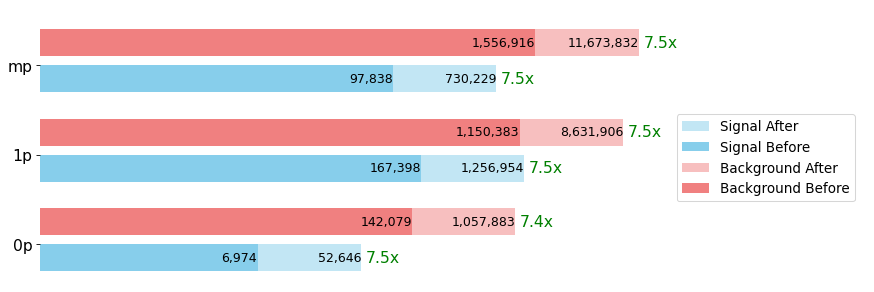

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import atlas_mpl_style as ampl
# ampl.use_atlas_style()
# Data
categories = ['0p', '1p', 'mp']
sig_before = [6974, 167398, 97838]
bkg_before = [142079, 1150383, 1556916]
sig_after = [52646, 1256954, 730229]
bkg_after = [1057883, 8631906, 11673832]

# Calculate improvement
sig_improvement = [(after) / before if before != 0 else 0 
                   for before, after in zip(sig_before, sig_after)]
bkg_improvement = [(after ) / before if before != 0 else 0 
                   for before, after in zip(bkg_before, bkg_after)]


# Plot settings
bar_width = 0.3
index = np.arange(len(categories))

fig, ax = plt.subplots(figsize=(12, 4),dpi=75)

# Plotting bars with overlap
bar2 = ax.barh(index, sig_after, bar_width, label='Signal After', color='skyblue', alpha=0.5)
bar1 = ax.barh(index, sig_before, bar_width, label='Signal Before', color='skyblue')

bar4 = ax.barh(index + bar_width + 0.1, bkg_after, bar_width, label='Background After', color='lightcoral', alpha=0.5)
bar3 = ax.barh(index + bar_width + 0.1, bkg_before, bar_width, label='Background Before', color='lightcoral')

# Adding labels and title
# ax.set_xlabel('Number of Jets')
ax.set_yticks(index + bar_width / 2)
ax.set_yticklabels(categories, fontsize=15)

# Adding grid for readability
# ax.grid(True, linestyle='--', alpha=0.6)

# Adding value annotations on the bars
for bars in [bar1, bar2, bar3, bar4]:
    for bar in bars:
        ax.text(bar.get_width()-100, bar.get_y() + bar.get_height() / 2,
                f'{int(bar.get_width()):_}', va='center', ha='right', fontsize=12)

# Adding percentage improvement annotations at the end of "after" bars
for i, (sig_imp, bkg_imp) in enumerate(zip(sig_improvement, bkg_improvement)):
    # Signal percentage improvement
    ax.text(sig_after[i] * 1.1, index[i], f'{sig_imp:.1f}x', 
            va='center', ha='left', fontsize=15, color='green')
    
    # Background percentage improvement
    ax.text(bkg_after[i] * 1.1, index[i] + bar_width + 0.1, f'{bkg_imp:.1f}x', 
            va='center', ha='left', fontsize=15, color='green')

# Removing all axes, ticks, and labels
ax.set_frame_on(False)
ax.xaxis.set_visible(False)# ax.set_yticks([])

ax.set_ylim(-0.3, len(categories) - 0.5+0.3)
ax.legend(loc=(0.77,0.3), fontsize = 13)
# ampl.draw_atlas_label(0.02,0.95,status='Simulation Internal', energy='13.6 TeV, ttbar semi-lep',fontsize=15)
plt.xlim(10**2,10**9)
plt.xscale('symlog')
plt.tight_layout()
plt.savefig('ttbar_num_jets.pdf')
plt.show()



In [71]:
15/2

7.5

In [ ]:
import os,h5py
import numpy as np
import matplotlib.pyplot as plt
import atlas_mpl_style as ampl
plt.figure(figsize=(10, 6),dpi=100)
prong = 'mp'
split = 'test'
type = 'background' 
path = '/home/aponnu/Desktop/AthulFiles/upp_output/'
density = False
log = True
sample_ids = [0,1,5,6]
sample_names = ['gammatautau','dijet','ttbar','Ztautau']
h5_paths = []
for root, dirs, files in os.walk(path+prong+f'/components/{split}'):
    for file in files:
        full_path = os.path.join(root, file)
        if type in full_path:
            h5_paths.append(full_path)
pt = {}
for i,id in enumerate(sample_ids):
    sample_array = np.array([])
    for h5_path in h5_paths:
        jets = h5py.File(h5_path, 'r')['jets']
        sample_column = jets['TauJets.Sample'][:]
        mask = (sample_column == id) if id != 1 else np.isin(sample_column, [1, 2, 3, 4])
        sample_array = np.concatenate((sample_array, jets['TauJets.pt'][mask]))
    pt[sample_names[i]] = sample_array

#############################################################################
# After umami
#############################################################################

path = '/home/aponnu/Desktop/ColdStorage/labelled_datasets/'
pt_before = {}
h5_paths = []
for root, dirs, files in os.walk(path):
    for file in files:
        full_path = os.path.join(root, file)
        if 'OLD' not in full_path and 'vds' not in full_path and type.upper() in full_path.upper() and prong in full_path:
            h5_paths.append(full_path)

for sample in sample_names:
    sample_array = np.array([])
    for h5_path in h5_paths:
        if sample not in h5_path:
            continue
        jets = h5py.File(h5_path, 'r')['jets']
        sample_array = np.concatenate((sample_array, jets['TauJets.pt']))
    pt_before[sample] = sample_array

sample_name = [r'$\gamma \rightarrow \tau\tau$','di-jet',r'$t\bar{t}$',r'$Z \rightarrow \tau\tau$']
cmap = plt.cm.get_cmap('tab10', len(pt.keys()))
for i,key in enumerate(pt.keys()):
    plt.hist(pt[key]/1000, bins=50, range=[0,500], log=True, histtype='step', density=density, color=cmap(i), linestyle='--', linewidth=1)
    plt.hist(pt_before[key]/1000, bins=50 ,range=[0,500], log=True, label=sample_name[i], histtype='step', density=density,color=cmap(i), linewidth=1)
plt.legend(ncol=2, loc='upper right')
plt.xlim(0,505)
ampl.draw_atlas_label(0.05,0.95,status='Simulation Internal', energy='13.6 TeV',desc=f'{prong} {split} {type}, ',fontsize=15)
plt.xlabel('pT [GeV]')
ax = plt.gca()
ymin, ymax = ax.get_ylim()
plt.ylim(ymin, ymax * 10)
plt.ylabel('Number of jets')
plt.yscale('symlog') if log else None
plt.tight_layout()
plt.savefig(f'{prong}_{split}_{type}_pt_change.pdf')
plt.show()

In [ ]:
# Train Val Test Pie Chart Maker
import h5py
import matplotlib.pyplot as plt

prongs =['0','1','m']
samples = ['signal','background']

for prong in prongs:
    for sample in samples:
        if sample == 'signal':
            # Paths to the HDF5 files
            val_path = f'/home/aponnu/Desktop/AthulFiles/upp_output/{prong}p/components/val/inclusive_tau_bjets.h5'
            train_path = f'/home/aponnu/Desktop/AthulFiles/upp_output/{prong}p/components/train/inclusive_tau_bjets.h5'
            test_path = f'/home/aponnu/Desktop/AthulFiles/upp_output/{prong}p/components/test/inclusive_tau_bjets.h5'

        if sample == 'background':
            # Paths to the HDF5 files
            val_path = f'/home/aponnu/Desktop/AthulFiles/upp_output/{prong}p/components/val/inclusive_qcd_ujets.h5'
            train_path = f'/home/aponnu/Desktop/AthulFiles/upp_output/{prong}p/components/train/inclusive_qcd_ujets.h5'
            test_path = f'/home/aponnu/Desktop/AthulFiles/upp_output/{prong}p/components/test/inclusive_qcd_ujets.h5'
            sample_text = 'bkgd'

        # Function to count jets in a given HDF5 file
        def count_jets(hdf5_path):
            with h5py.File(hdf5_path, 'r') as file:
                # Assuming the dataset containing jets is named 'jets'
                jets_dataset = file['jets']
                jet_count = len(jets_dataset)
            return jet_count

        # Count jets in each dataset
        jet_count_val = count_jets(val_path)
        jet_count_train = count_jets(train_path)
        jet_count_test= count_jets(test_path)

        print(f'{prong}prong {sample}')
        print(f'Train:{jet_count_train} | Val:{jet_count_val} | Test:{jet_count_test}')
        print('\n')
        # Prepare data for the donut chart
        labels = ['Train', 'Validation', 'Test']
        sizes = [jet_count_train, jet_count_val, jet_count_test]
        colors = ['#ff9999','#66b3ff','#99ff99']

        # Calculate the total number of jets
        total_jets = sum(sizes)

        # Create the donut chart
        fig, ax = plt.subplots()
        ax.pie(sizes, labels=labels, colors=colors, autopct='%1.1f%%', startangle=90, pctdistance=0.8, textprops={'fontsize': 19})
        center_circle = plt.Circle((0,0),0.60,fc='white')
        fig.gca().add_artist(center_circle)

        # Add text in the center of the donut chart
        ax.text(0, 0, f'{prong}-prong \n{sample}\n\nTotal Jets:\n{total_jets:_}', ha='center', va='center', fontsize=18)

        # Equal aspect ratio ensures that pie is drawn as a circle.
        ax.axis('equal')  
        fig.tight_layout()
        plt.savefig(f'/home/aponnu/Desktop/ColdStorage/.plots/others/{prong}p_{sample}_train-val-test.pdf')
    
plt.close('all')

In [7]:
# Variable plotter

import h5py, os
import numpy as np
import matplotlib.pyplot as plt
import atlas_mpl_style as ampl

variable = 'TauTracks.d0TJVA'
before_path = '/home/aponnu/Desktop/ColdStorage/labelled_datasets/'
after_path = '/home/aponnu/Desktop/AthulFiles/upp_output_v0/'
prongs = ['0p', '1p', 'mp']
process_key = {0: 'gammatautau', 1: 'dijet',2: 'dijet', 3: 'dijet', 4: 'dijet', 5: 'ttbar', 6: 'Ztautau'}
for prong in prongs:
    before_paths = []
    for root, dirs, files in os.walk(before_path + prong):
        for file in files:
            if file.endswith('.h5') and 'vds' not in root and 'OLD' not in root:
                full_path = os.path.join(root, file)
                before_paths.append(full_path)

    sig_var = {}
    bg_var = {}

    for path in before_paths:
        f = h5py.File(path, 'r')
        jets = f['jets']
        tracks = f['tracks']
        process = np.unique(jets['TauJets.Sample'])[0]

        if process in [1, 2, 3, 4]:
            process = 1

        if 'Signal' in path:
            if process in sig_var:
                sig_var[process] = np.concatenate((sig_var[process], tracks[variable].flatten()))
            else:
                sig_var[process] = tracks[variable].flatten()
                
        if 'Background' in path:
            if process in bg_var:
                bg_var[process] = np.concatenate((bg_var[process], tracks[variable].flatten()))
            else:
                bg_var[process] = tracks[variable].flatten()
    
    for key, val in sig_var.items():
        plt.hist(val, bins=100, histtype='step', label=f'{process_key[key]} Signal',density=True)
    plt.legend()
    # plt.yscale('log')
    plt.xlabel(variable)
    plt.ylabel('Normalized Counts')
    plt.savefig(f'{prong}_Sig_{variable}.pdf',bbox_inches='tight')
    plt.show()
    plt.close()

    for key, val in bg_var.items():
        plt.hist(val, bins=100, histtype='step', label=f'{process_key[key]} Background', density=True)
    plt.legend()
    # plt.yscale('log')
    plt.xlabel(variable)
    plt.ylabel('Normalized Counts')
    plt.savefig(f'{prong}_Bg_{variable}.pdf',bbox_inches='tight')
    plt.show()
    plt.close()



KeyboardInterrupt: 

In [21]:
# Track and Cluster plotter
import os,h5py
import numpy as np
prong='1p'
dir_path = f'/home/aponnu/Desktop/ColdStorage/labelled_datasets/{prong}'
signal_track = []
h5_paths=[]
for root, dirs, files in os.walk(dir_path):
    for file in files:
        full_path = os.path.join(root, file)
        if 'OLD' not in full_path and 'vds' not in full_path:
            h5_paths.append(full_path)

sig_tracks_count = np.array([])
sig_clusters_count = np.array([])
bkg_tracks_count = np.array([])
bkg_clusters_count = np.array([])
for path in h5_paths:
    file = h5py.File(path, 'r')
    trackpT= file['tracks']['TauTracks.pt']
    clusterpT = file['cells']['TauClusters.e']
    if 'Signal' in path:
        sig_tracks_count = np.concatenate([sig_tracks_count,np.sum(~np.isnan(trackpT), axis=1)])
        sig_clusters_count = np.concatenate([sig_clusters_count,np.sum(~np.isnan(clusterpT), axis=1)])
    if 'Background' in path:
        bkg_tracks_count = np.concatenate([bkg_tracks_count,np.sum(~np.isnan(trackpT), axis=1)])
        bkg_clusters_count = np.concatenate([bkg_clusters_count,np.sum(~np.isnan(clusterpT), axis=1)])

# plt.hist(sig_tracks_count)


(array([ 1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11., 12., 13.,
       14., 15., 16., 17., 18., 19., 20.]), array([   3661,   18422,   50301,  103202,  176404,  263019,  362015,
        469538,  577558,  687076,  790589,  886063,  968814, 1034037,
       1078025, 1096794, 1087777, 1056150,  999030, 5840612]))
(array([ 1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11., 12., 13.,
       14., 15., 16., 17., 18., 19., 20.]), array([    484,    2319,    6719,   15189,   28722,   50367,   78676,
        115675,  159057,  210782,  267560,  327892,  390638,  455939,
        515241,  572607,  618586,  657846,  685908, 8019639]))


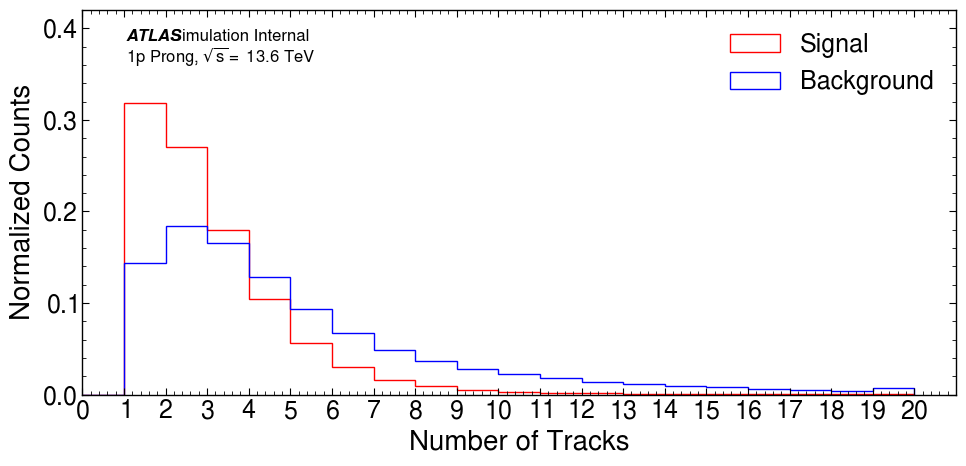

In [48]:
import matplotlib.pyplot as plt
import atlas_mpl_style as ampl
print(np.unique(sig_clusters_count, return_counts=True))
print(np.unique(bkg_clusters_count, return_counts=True))

ampl.use_atlas_style()
plt.figure(figsize=(10, 5),dpi=100)
plt.hist(sig_tracks_count, bins=20, range=[0,20], histtype='step', label='Signal', color='red', density=True,linewidth=1)
plt.hist(bkg_tracks_count, bins=20, range=[0,20], histtype='step', label='Background', color='blue',density=True,linewidth=1)
plt.xticks(range(0,21))
plt.legend()
ax = plt.gca()
ymin, ymax = ax.get_ylim()
plt.ylim(ymin, ymax*1.2)
plt.xlim(0,21)
ampl.draw_atlas_label(0.05,0.95,status='Simulation Internal', energy='13.6 TeV',desc=f'{prong} Prong, ',fontsize=12)
plt.xlabel('Number of Tracks')
plt.ylabel('Normalized Counts')
plt.tight_layout()
plt.savefig(f'{prong}_tracks_count.pdf')
plt.show()


ampl.use_atlas_style()
plt.figure(figsize=(10, 5),dpi=100)
plt.hist(sig_clusters_count, bins=21, range=[0,21], histtype='step', label='Signal', color='red', density=True,linewidth=1)
plt.hist(bkg_clusters_count, bins=21, range=[0,21], histtype='step', label='Background', color='blue',density=True,linewidth=1)
plt.xticks(range(0,22))
plt.legend()
ax = plt.gca()
ymin, ymax = ax.get_ylim()
plt.ylim(ymin, ymax*1.2)
plt.xlim(0,22)
ampl.draw_atlas_label(0.05,0.95,status='Simulation Internal', energy='13.6 TeV',desc=f'{prong} Prong, ',fontsize=12)
plt.xlabel('Number of Clusters')
plt.ylabel('Normalized Counts')
plt.tight_layout()
plt.savefig(f'{prong}_cluster_count.pdf')
plt.show()